In [1]:
import os
import shutil
from bmtk.builder.networks import NetworkBuilder
from bmtk.utils.sim_setup import build_env_bionet
from bmtk.simulator import bionet

import h5py
import matplotlib.pyplot as plt
import numpy as np
from workshop2025_activityutils import calc_rate_loss

## Goal: Create a biophysical neuron model with 3 virtual input populations, that replicates the provided target output trace.

Provided:
* cell morphology
* cell dynamic param file
* synapse templates
* synapse dynamic param files
* Input population spike files

Fill in the blanks for each section to simulate a biophysical neuron targetted by 3 distinct input populations. Try to match the target output as closely as possible. If there is a mismatch test out different combinations of parameter choices.

Use tutorial 2 as a reference. 

### Step 1: Build a biophysical neuron

In [2]:
base_dir = './activity_files'

test_file_dir = os.path.join(base_dir, 'test_files') # dir to provided files
net_dir = os.path.join(test_file_dir, 'network')
input_dir = os.path.join(base_dir, 'inputs')
test_path = os.path.join(test_file_dir, 'output')
target_path = os.path.join(base_dir, 'targets')

if os.path.exists(net_dir):
    shutil.rmtree(net_dir)

# Build the biophysical neuron
# fill in the blanks here, look at tutorial 2 if you need help
bneuron = NetworkBuilder('bneuron')
bneuron.add_nodes(
    cell_name='biophysical_neuron',
    potential='exc',
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    model_processing='aibs_perisomatic',
    dynamics_params='473863035_fit.json', # dynamics parameters for the neuron, look at this file to see what parameters are used, do you know what each represents?
    morphology='Rorb_325404214_m.swc' # feel free to play around with different morphologies, do they significantly change the results?
)


bneuron.build()
bneuron.save_nodes(output_dir= net_dir)

### Step 2: Define the input populations

Choose the name of the first input population and create 2 more 'virtual' input populations.


In [3]:
# Input network 1 
input1 = NetworkBuilder('input1')
input1.add_nodes(
    N=10,
    pop_name='input1',
    potential='exc',
    model_type='virtual'
)

# Input network 2 
input2 = NetworkBuilder('input2')
input2.add_nodes(
    N=10,
    pop_name='input2',
    potential='exc',
    model_type='virtual'
)

# Input network 3
input3 = NetworkBuilder('input3')
input3.add_nodes(
    N=5,
    pop_name='input3',
    potential='inh',
    model_type='virtual'
)

### Step 3: Connect the inputs to the main neuron

This is where you design the connection rule between your inputs and target neuron! What does each argument do? How do you choose what to put? 

If your simulation output looks different from the target play around with these fields, how does each one change the resulting output?

(Hint: you might also need to modify the potential of your input networks)

In [4]:
# Connect the input network to the main network
input1.add_edges(
    source={'pop_name': 'input1'}, target=bneuron.nodes(),
    connection_rule=10,
    syn_weight=0.001,
    delay=2.0,
    weight_function=None,
    target_sections=['basal'],
    distance_range=[0.0, 150.0],
    dynamics_params='AMPA_ExcToExc.json',
    model_template='exp2syn'
)

# Connect the input network to the main network
input2.add_edges(
    source={'pop_name': 'input2'}, target=bneuron.nodes(),
    connection_rule=5,
    syn_weight=0.01,
    delay=2.0,
    weight_function=None,
    target_sections=['apical'],
    distance_range=[0.0, 150.0],
    dynamics_params='AMPA_ExcToExc.json',
    model_template='exp2syn'
)

# Connect the input network to the main network
input3.add_edges(
    source={'pop_name': 'input3'}, target=bneuron.nodes(),
    connection_rule=5,
    syn_weight=0.001,
    delay=2.0,
    weight_function=None,
    target_sections=['soma'],
    distance_range=[0.0, 150.0],
    dynamics_params='GABA_InhToExc.json',
    model_template='exp2syn'
)

input1.build()
input1.save_nodes(output_dir=net_dir)
input1.save_edges(output_dir=net_dir)

input2.build()
input2.save_nodes(output_dir=net_dir)
input2.save_edges(output_dir=net_dir)

input3.build()
input3.save_nodes(output_dir=net_dir)
input3.save_edges(output_dir=net_dir)


### Step 4: Build the network and run the simulation

If this cell throws a hocobj_call error try restarting the kernel and running again. 

In [5]:
dt = 0.01  # time step for the simulation
build_env_bionet(
    base_dir=test_file_dir,
    config_file='config.json',
    network_dir=net_dir,
    tstop=3000.0, dt=dt,
    report_vars=['v', 'cai'],    # Record membrane potential and calcium (default recording from the soma)
    spikes_inputs=[('input1', 
                    os.path.join(input_dir, 'input1_spikes.h5')),
                    ('input2', 
                    os.path.join(input_dir,'input2_spikes.h5')),
                    ('input3', 
                    os.path.join(input_dir,'input3_spikes.h5'))],
    include_examples=True,       # Copies components files, only run once set to false after
    compile_mechanisms=True,      # Will try to compile NEURON mechanisms, only run once set to false after
    overwrite_config=True, # Overwrite the config file if it exists
)

conf = bionet.Config.from_json(os.path.join(test_file_dir,'config.json'))
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

/Users/elena.westeinde/miniforge3/envs/bmtk_new/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/elena.westeinde/Code/bmtk/workshop2025/activity_files/test_files/components/mechanisms
Mod files: "modfiles/modfiles/CaDynamics.mod" "modfiles/modfiles/Ca_HVA.mod" "modfiles/modfiles/Ca_LVA.mod" "modfiles/modfiles/Ih.mod" "modfiles/modfiles/Im.mod" "modfiles/modfiles/Im_v2.mod" "modfiles/modfiles/K_P.mod" "modfiles/modfiles/K_T.mod" "modfiles/modfiles/Kd.mod" "modfiles/modfiles/Kv2like.mod" "modfiles/modfiles/Kv3_1.mod" "modfiles/modfiles/NaTa.mod" "modfiles/modfiles/NaTs.mod" "modfiles/modfiles/NaV.mod" "modfiles/modfiles/Nap.mod" "modfiles/modfiles/SK.mod" "modfiles/modfiles/vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special
2025-07-02 17:00:12,078 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2025-07-02 17:00:12,508 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2025-07-02 17:00:12,541 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2025-07-02 17:00:12,542 [INFO] Building virtual cell stimulations for input1_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for input1_spikes


2025-07-02 17:00:12,602 [INFO] Building virtual cell stimulations for input2_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for input2_spikes


2025-07-02 17:00:12,616 [INFO] Building virtual cell stimulations for input3_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for input3_spikes


2025-07-02 17:00:12,662 [INFO] Running simulation for 3000.000 ms with the time step 0.010 ms


INFO:NEURONIOUtils:Running simulation for 3000.000 ms with the time step 0.010 ms


2025-07-02 17:00:12,663 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2025-07-02 17:00:12,663 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2025-07-02 17:00:12,783 [INFO]     step:5000 t_sim:50.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:50.00 ms


2025-07-02 17:00:12,882 [INFO]     step:10000 t_sim:100.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:100.00 ms


2025-07-02 17:00:12,996 [INFO]     step:15000 t_sim:150.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:150.00 ms


2025-07-02 17:00:13,090 [INFO]     step:20000 t_sim:200.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:200.00 ms


2025-07-02 17:00:13,226 [INFO]     step:25000 t_sim:250.00 ms


INFO:NEURONIOUtils:    step:25000 t_sim:250.00 ms


2025-07-02 17:00:13,333 [INFO]     step:30000 t_sim:300.00 ms


INFO:NEURONIOUtils:    step:30000 t_sim:300.00 ms


2025-07-02 17:00:13,466 [INFO]     step:35000 t_sim:350.00 ms


INFO:NEURONIOUtils:    step:35000 t_sim:350.00 ms


2025-07-02 17:00:13,566 [INFO]     step:40000 t_sim:400.00 ms


INFO:NEURONIOUtils:    step:40000 t_sim:400.00 ms


2025-07-02 17:00:13,692 [INFO]     step:45000 t_sim:450.00 ms


INFO:NEURONIOUtils:    step:45000 t_sim:450.00 ms


2025-07-02 17:00:13,786 [INFO]     step:50000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:50000 t_sim:500.00 ms


2025-07-02 17:00:13,903 [INFO]     step:55000 t_sim:550.00 ms


INFO:NEURONIOUtils:    step:55000 t_sim:550.00 ms


2025-07-02 17:00:13,992 [INFO]     step:60000 t_sim:600.00 ms


INFO:NEURONIOUtils:    step:60000 t_sim:600.00 ms


2025-07-02 17:00:14,102 [INFO]     step:65000 t_sim:650.00 ms


INFO:NEURONIOUtils:    step:65000 t_sim:650.00 ms


2025-07-02 17:00:14,189 [INFO]     step:70000 t_sim:700.00 ms


INFO:NEURONIOUtils:    step:70000 t_sim:700.00 ms


2025-07-02 17:00:14,297 [INFO]     step:75000 t_sim:750.00 ms


INFO:NEURONIOUtils:    step:75000 t_sim:750.00 ms


2025-07-02 17:00:14,382 [INFO]     step:80000 t_sim:800.00 ms


INFO:NEURONIOUtils:    step:80000 t_sim:800.00 ms


2025-07-02 17:00:14,484 [INFO]     step:85000 t_sim:850.00 ms


INFO:NEURONIOUtils:    step:85000 t_sim:850.00 ms


2025-07-02 17:00:14,565 [INFO]     step:90000 t_sim:900.00 ms


INFO:NEURONIOUtils:    step:90000 t_sim:900.00 ms


2025-07-02 17:00:14,669 [INFO]     step:95000 t_sim:950.00 ms


INFO:NEURONIOUtils:    step:95000 t_sim:950.00 ms


2025-07-02 17:00:14,750 [INFO]     step:100000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:100000 t_sim:1000.00 ms


2025-07-02 17:00:14,852 [INFO]     step:105000 t_sim:1050.00 ms


INFO:NEURONIOUtils:    step:105000 t_sim:1050.00 ms


2025-07-02 17:00:14,932 [INFO]     step:110000 t_sim:1100.00 ms


INFO:NEURONIOUtils:    step:110000 t_sim:1100.00 ms


2025-07-02 17:00:15,033 [INFO]     step:115000 t_sim:1150.00 ms


INFO:NEURONIOUtils:    step:115000 t_sim:1150.00 ms


2025-07-02 17:00:15,107 [INFO]     step:120000 t_sim:1200.00 ms


INFO:NEURONIOUtils:    step:120000 t_sim:1200.00 ms


2025-07-02 17:00:15,205 [INFO]     step:125000 t_sim:1250.00 ms


INFO:NEURONIOUtils:    step:125000 t_sim:1250.00 ms


2025-07-02 17:00:15,279 [INFO]     step:130000 t_sim:1300.00 ms


INFO:NEURONIOUtils:    step:130000 t_sim:1300.00 ms


2025-07-02 17:00:15,375 [INFO]     step:135000 t_sim:1350.00 ms


INFO:NEURONIOUtils:    step:135000 t_sim:1350.00 ms


2025-07-02 17:00:15,449 [INFO]     step:140000 t_sim:1400.00 ms


INFO:NEURONIOUtils:    step:140000 t_sim:1400.00 ms


2025-07-02 17:00:15,554 [INFO]     step:145000 t_sim:1450.00 ms


INFO:NEURONIOUtils:    step:145000 t_sim:1450.00 ms


2025-07-02 17:00:15,628 [INFO]     step:150000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:150000 t_sim:1500.00 ms


2025-07-02 17:00:15,725 [INFO]     step:155000 t_sim:1550.00 ms


INFO:NEURONIOUtils:    step:155000 t_sim:1550.00 ms


2025-07-02 17:00:15,799 [INFO]     step:160000 t_sim:1600.00 ms


INFO:NEURONIOUtils:    step:160000 t_sim:1600.00 ms


2025-07-02 17:00:15,897 [INFO]     step:165000 t_sim:1650.00 ms


INFO:NEURONIOUtils:    step:165000 t_sim:1650.00 ms


2025-07-02 17:00:15,971 [INFO]     step:170000 t_sim:1700.00 ms


INFO:NEURONIOUtils:    step:170000 t_sim:1700.00 ms


2025-07-02 17:00:16,068 [INFO]     step:175000 t_sim:1750.00 ms


INFO:NEURONIOUtils:    step:175000 t_sim:1750.00 ms


2025-07-02 17:00:16,142 [INFO]     step:180000 t_sim:1800.00 ms


INFO:NEURONIOUtils:    step:180000 t_sim:1800.00 ms


2025-07-02 17:00:16,239 [INFO]     step:185000 t_sim:1850.00 ms


INFO:NEURONIOUtils:    step:185000 t_sim:1850.00 ms


2025-07-02 17:00:16,312 [INFO]     step:190000 t_sim:1900.00 ms


INFO:NEURONIOUtils:    step:190000 t_sim:1900.00 ms


2025-07-02 17:00:16,410 [INFO]     step:195000 t_sim:1950.00 ms


INFO:NEURONIOUtils:    step:195000 t_sim:1950.00 ms


2025-07-02 17:00:16,484 [INFO]     step:200000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:200000 t_sim:2000.00 ms


2025-07-02 17:00:16,583 [INFO]     step:205000 t_sim:2050.00 ms


INFO:NEURONIOUtils:    step:205000 t_sim:2050.00 ms


2025-07-02 17:00:16,658 [INFO]     step:210000 t_sim:2100.00 ms


INFO:NEURONIOUtils:    step:210000 t_sim:2100.00 ms


2025-07-02 17:00:16,757 [INFO]     step:215000 t_sim:2150.00 ms


INFO:NEURONIOUtils:    step:215000 t_sim:2150.00 ms


2025-07-02 17:00:16,831 [INFO]     step:220000 t_sim:2200.00 ms


INFO:NEURONIOUtils:    step:220000 t_sim:2200.00 ms


2025-07-02 17:00:16,929 [INFO]     step:225000 t_sim:2250.00 ms


INFO:NEURONIOUtils:    step:225000 t_sim:2250.00 ms


2025-07-02 17:00:17,003 [INFO]     step:230000 t_sim:2300.00 ms


INFO:NEURONIOUtils:    step:230000 t_sim:2300.00 ms


2025-07-02 17:00:17,104 [INFO]     step:235000 t_sim:2350.00 ms


INFO:NEURONIOUtils:    step:235000 t_sim:2350.00 ms


2025-07-02 17:00:17,178 [INFO]     step:240000 t_sim:2400.00 ms


INFO:NEURONIOUtils:    step:240000 t_sim:2400.00 ms


2025-07-02 17:00:17,276 [INFO]     step:245000 t_sim:2450.00 ms


INFO:NEURONIOUtils:    step:245000 t_sim:2450.00 ms


2025-07-02 17:00:17,357 [INFO]     step:250000 t_sim:2500.00 ms


INFO:NEURONIOUtils:    step:250000 t_sim:2500.00 ms


2025-07-02 17:00:17,454 [INFO]     step:255000 t_sim:2550.00 ms


INFO:NEURONIOUtils:    step:255000 t_sim:2550.00 ms


2025-07-02 17:00:17,528 [INFO]     step:260000 t_sim:2600.00 ms


INFO:NEURONIOUtils:    step:260000 t_sim:2600.00 ms


2025-07-02 17:00:17,626 [INFO]     step:265000 t_sim:2650.00 ms


INFO:NEURONIOUtils:    step:265000 t_sim:2650.00 ms


2025-07-02 17:00:17,702 [INFO]     step:270000 t_sim:2700.00 ms


INFO:NEURONIOUtils:    step:270000 t_sim:2700.00 ms


2025-07-02 17:00:17,801 [INFO]     step:275000 t_sim:2750.00 ms


INFO:NEURONIOUtils:    step:275000 t_sim:2750.00 ms


2025-07-02 17:00:17,877 [INFO]     step:280000 t_sim:2800.00 ms


INFO:NEURONIOUtils:    step:280000 t_sim:2800.00 ms


2025-07-02 17:00:17,979 [INFO]     step:285000 t_sim:2850.00 ms


INFO:NEURONIOUtils:    step:285000 t_sim:2850.00 ms


2025-07-02 17:00:18,055 [INFO]     step:290000 t_sim:2900.00 ms


INFO:NEURONIOUtils:    step:290000 t_sim:2900.00 ms


2025-07-02 17:00:18,151 [INFO]     step:295000 t_sim:2950.00 ms


INFO:NEURONIOUtils:    step:295000 t_sim:2950.00 ms


2025-07-02 17:00:18,225 [INFO]     step:300000 t_sim:3000.00 ms


INFO:NEURONIOUtils:    step:300000 t_sim:3000.00 ms


2025-07-02 17:00:18,243 [INFO] Simulation completed in 5.581 seconds 


INFO:NEURONIOUtils:Simulation completed in 5.581 seconds 


### Step 5: Examine results and compare to target traces

(43,)
Number of Target Spikes: 43
Number of Test Spikes: 43
Rate loss: 0.0


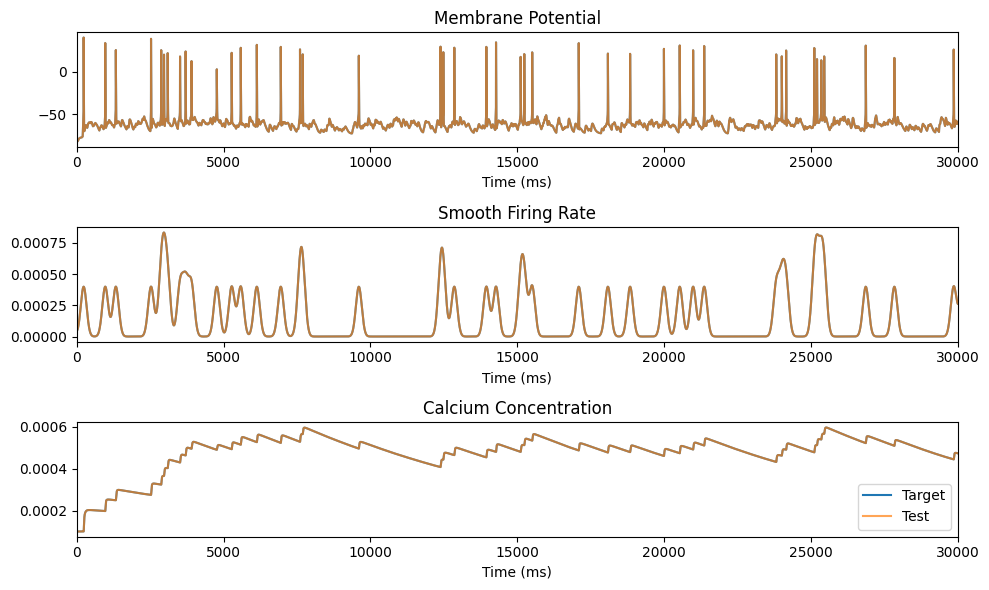

In [6]:
# load in the simulation output files
with h5py.File(os.path.join(test_path, 'v_report.h5'), 'r') as file:
    test_vData = file['report']['bneuron']['data'][:]

with h5py.File(os.path.join(test_path, 'cai_report.h5'), 'r') as file:
    test_cData = file['report']['bneuron']['data'][:]

with h5py.File(os.path.join(test_path, 'spikes.h5'), 'r') as file:
    print(file['spikes']['bneuron']['timestamps'].shape)
    test_spikes = file['spikes']['bneuron']['timestamps'][:]

# load in target data
with h5py.File(os.path.join(target_path, 'v_report.h5'), 'r') as file:
    target_vData = file['report']['bneuron']['data'][:]

with h5py.File(os.path.join(target_path, 'cai_report.h5'), 'r') as file:
    target_cData = file['report']['bneuron']['data'][:]

with h5py.File(os.path.join(target_path, 'spikes.h5'), 'r') as file:
    target_spikes = file['spikes']['bneuron']['timestamps'][:]

# calculate the rate loss
rate_loss, target_rate, test_rate = calc_rate_loss(test_vData, target_vData, -10, dt, 1000)

# plot target and test data
time = np.linspace(0, len(target_vData) * 0.1, len(target_vData))
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(time, target_vData)
ax[0].plot(time, test_vData, alpha = 0.7)
ax[0].set_title('Membrane Potential')
ax[0].set_xlabel('Time (ms)')
ax[0].set_xlim([min(time), max(time)])

ax[1].plot(time, target_rate)
ax[1].plot(time, test_rate, alpha = 0.7)
ax[1].set_title('Smooth Firing Rate')
ax[1].set_xlabel('Time (ms)')
ax[1].set_xlim([min(time), max(time)])

ax[2].plot(time, target_cData, label='Target')
ax[2].plot(time, test_cData, label='Test', alpha = 0.7)
ax[2].legend()
ax[2].set_title('Calcium Concentration')
ax[2].set_xlabel('Time (ms)')
ax[2].set_xlim([min(time), max(time)])

plt.tight_layout()

print('Number of Target Spikes: {}'.format(len(target_spikes)))
print('Number of Test Spikes: {}'.format(len(test_spikes)))
print(f'Rate loss: {rate_loss}')
